In [131]:
import boto3
import pandas as pd
from io import StringIO
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [132]:
# Définir les infos de ton bucket S3
bucket_name = "bucketdeployment"
file_key = "mlflow-doctolib/doctolib_simplified_dataset_01.csv"

# Initialiser le client S3
s3 = boto3.client("s3")

# Télécharger le fichier dans un objet en mémoire
response = s3.get_object(Bucket=bucket_name, Key=file_key)

# Lire le fichier CSV depuis la réponse S3
dataset = pd.read_csv(StringIO(response["Body"].read().decode("utf-8")))

# Afficher les premières lignes
print("Dataset loaded successfully. Here are the first few rows:")
display(dataset.head())

Dataset loaded successfully. Here are the first few rows:


,Unnamed: 0,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,Quartier Saint-Germain-l'Auxerrois,0,1,0,0,0,0,No
1,1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,Quartier Saint-Germain-l'Auxerrois,0,0,0,0,0,0,No
2,2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,Quartier des Halles,0,0,0,0,0,0,No
3,3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,Quartier du Palais-Royal,0,0,0,0,0,0,No
4,4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,Quartier Saint-Germain-l'Auxerrois,0,1,1,0,0,0,No


In [133]:
# Affichage du nombre de lignes dans le dataset
print(f"Number of rows: {dataset.shape[0]}\n")
print(f"Number of columns: {dataset.shape[1]}\n")

# Affichage des premières lignes du dataset
print("Display of dataset (first 5 rows):")
display(dataset.head())
print()

# Statistiques descriptives de base pour le dataset
print("Basic statistics: ")
data_desc = dataset.describe(include='all')
display(data_desc)
print()

# Calcul et affichage du pourcentage de valeurs manquantes par colonne
print("Percentage of missing values per column: ")
missing_values = (100 * dataset.isnull().sum() / dataset.shape[0]).round(2)
display(missing_values)

Number of rows: 110527

Number of columns: 15

Display of dataset (first 5 rows):


,Unnamed: 0,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,Quartier Saint-Germain-l'Auxerrois,0,1,0,0,0,0,No
1,1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,Quartier Saint-Germain-l'Auxerrois,0,0,0,0,0,0,No
2,2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,Quartier des Halles,0,0,0,0,0,0,No
3,3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,Quartier du Palais-Royal,0,0,0,0,0,0,No
4,4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,Quartier Saint-Germain-l'Auxerrois,0,1,1,0,0,0,No



Basic statistics: 


,Unnamed: 0,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
count,110527.000000,1.105270e+05,1.105270e+05,110527,110527,110527,110527.000000,110527,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527
unique,NaN,NaN,NaN,2,103549,27,NaN,81,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,F,2016-05-06T07:09:54Z,2016-06-06T00:00:00Z,NaN,Quartier de l'Odéon,NaN,NaN,NaN,NaN,NaN,NaN,No
freq,NaN,NaN,NaN,71840,24,4692,NaN,7717,NaN,NaN,NaN,NaN,NaN,NaN,88208
mean,55263.000000,1.474963e+14,5.675305e+06,NaN,NaN,NaN,37.088874,NaN,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,NaN
std,31906.540939,2.560949e+14,7.129575e+04,NaN,NaN,NaN,23.110205,NaN,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,NaN
min,0.000000,3.921784e+04,5.030230e+06,NaN,NaN,NaN,-1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,27631.500000,4.172614e+12,5.640286e+06,NaN,NaN,NaN,18.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,55263.000000,3.173184e+13,5.680573e+06,NaN,NaN,NaN,37.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
75%,82894.500000,9.439172e+13,5.725524e+06,NaN,NaN,NaN,55.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN



Percentage of missing values per column: 


Unnamed: 0        0.0
PatientId         0.0
AppointmentID     0.0
Gender            0.0
ScheduledDay      0.0
AppointmentDay    0.0
Age               0.0
Neighbourhood     0.0
Scholarship       0.0
Hypertension      0.0
Diabetes          0.0
Alcoholism        0.0
Handcap           0.0
SMS_received      0.0
No-show           0.0
dtype: float64

In [134]:
# Supprimer les 3 premières colonnes
dataset_filtered = dataset.iloc[:, 3:]
dataset_filtered.head()

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,Quartier Saint-Germain-l'Auxerrois,0,1,0,0,0,0,No
1,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,Quartier Saint-Germain-l'Auxerrois,0,0,0,0,0,0,No
2,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,Quartier des Halles,0,0,0,0,0,0,No
3,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,Quartier du Palais-Royal,0,0,0,0,0,0,No
4,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,Quartier Saint-Germain-l'Auxerrois,0,1,1,0,0,0,No


In [135]:
# s'assurer qu'il n'y ait pas de données manquantes
if not dataset_filtered.isnull().any().any():
    print("No missing values found in the dataset.")
else:
    print("There are missing values in the dataset.")

No missing values found in the dataset.


In [136]:
# Convertir ScheduledDay et AppointmentDay en datetime
dataset_filtered["ScheduledDay"] = pd.to_datetime(dataset_filtered["ScheduledDay"])
dataset_filtered["AppointmentDay"] = pd.to_datetime(dataset_filtered["AppointmentDay"])

# Vérifier les nouvelles colonnes
print("Type des colonnes après conversion:")
display(dataset_filtered.dtypes)

Type des colonnes après conversion:


Gender                         object
ScheduledDay      datetime64[ns, UTC]
AppointmentDay    datetime64[ns, UTC]
Age                             int64
Neighbourhood                  object
Scholarship                     int64
Hypertension                    int64
Diabetes                        int64
Alcoholism                      int64
Handcap                         int64
SMS_received                    int64
No-show                        object
dtype: object

In [137]:
# Créer une nouvelle feature "Délai RDV" en jours
dataset_filtered["DaysUntilAppointment"] = (dataset_filtered["AppointmentDay"] - dataset_filtered["ScheduledDay"]).dt.days

# Vérifier la distribution de la nouvelle feature
print(dataset_filtered["DaysUntilAppointment"].describe())

count    110527.000000
mean          9.183702
std          15.254996
min          -7.000000
25%          -1.000000
50%           3.000000
75%          14.000000
max         178.000000
Name: DaysUntilAppointment, dtype: float64


In [138]:
# Vérifier combien de RDVs ont un délai négatif
negative_delays = dataset_filtered[dataset_filtered["DaysUntilAppointment"] < 0]
print(f"Nombre de RDVs avec un délai négatif : {negative_delays.shape[0]}")

# Afficher quelques exemples pour voir le problème
display(negative_delays[["ScheduledDay", "AppointmentDay", "DaysUntilAppointment"]].head(10))

Nombre de RDVs avec un délai négatif : 38568


,ScheduledDay,AppointmentDay,DaysUntilAppointment
0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,-1
1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,-1
2,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,-1
3,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,-1
4,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,-1
8,2016-04-29 08:02:16+00:00,2016-04-29 00:00:00+00:00,-1
19,2016-04-29 10:43:14+00:00,2016-04-29 00:00:00+00:00,-1
24,2016-04-29 14:19:19+00:00,2016-04-29 00:00:00+00:00,-1
26,2016-04-29 14:19:42+00:00,2016-04-29 00:00:00+00:00,-1
28,2016-04-29 15:48:02+00:00,2016-04-29 00:00:00+00:00,-1


In [139]:
# Correction : Prendre la valeur absolue
dataset_filtered["DaysUntilAppointment"] = dataset_filtered["DaysUntilAppointment"].abs()

# Vérification après correction
print("📊 Nouvelle distribution après correction :")
display(dataset_filtered["DaysUntilAppointment"].describe())

# Vérifier les valeurs extrêmes
print("\n🧐 Exemples après correction :")
display(dataset_filtered[["ScheduledDay", "AppointmentDay", "DaysUntilAppointment"]].head(10))

📊 Nouvelle distribution après correction :


count    110527.000000
mean          9.881775
std          14.812349
min           0.000000
25%           1.000000
50%           3.000000
75%          14.000000
max         178.000000
Name: DaysUntilAppointment, dtype: float64


🧐 Exemples après correction :


,ScheduledDay,AppointmentDay,DaysUntilAppointment
0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,1
1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,1
2,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,1
3,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,1
4,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,1
5,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,1
6,2016-04-27 15:05:12+00:00,2016-04-29 00:00:00+00:00,1
7,2016-04-27 15:39:58+00:00,2016-04-29 00:00:00+00:00,1
8,2016-04-29 08:02:16+00:00,2016-04-29 00:00:00+00:00,1
9,2016-04-27 12:48:25+00:00,2016-04-29 00:00:00+00:00,1


In [140]:
outlier_threshold = 90  # On considère ici un RDV avec plus de 90 jours d'attente comme potentiellement anormal
outliers = dataset_filtered[dataset_filtered["DaysUntilAppointment"] > outlier_threshold]

print(f"Nombre de RDVs avec un délai supérieur à {outlier_threshold} jours : {len(outliers)}")
display(outliers[["ScheduledDay", "AppointmentDay", "DaysUntilAppointment"]].head(10))

Nombre de RDVs avec un délai supérieur à 90 jours : 161


,ScheduledDay,AppointmentDay,DaysUntilAppointment
953,2016-01-05 15:02:46+00:00,2016-04-29 00:00:00+00:00,114
954,2016-01-05 11:53:44+00:00,2016-04-29 00:00:00+00:00,114
955,2016-01-11 10:20:41+00:00,2016-04-29 00:00:00+00:00,108
956,2016-01-11 09:57:10+00:00,2016-04-29 00:00:00+00:00,108
957,2016-01-11 09:08:10+00:00,2016-04-29 00:00:00+00:00,108
958,2016-01-11 09:09:10+00:00,2016-04-29 00:00:00+00:00,108
959,2016-01-11 08:52:35+00:00,2016-04-29 00:00:00+00:00,108
3764,2015-11-10 07:13:56+00:00,2016-05-04 00:00:00+00:00,175
3849,2016-02-03 12:37:24+00:00,2016-05-16 00:00:00+00:00,102
17132,2016-01-14 13:36:52+00:00,2016-05-05 00:00:00+00:00,111


In [141]:
# Ajouter le jour de la semaine du RDV (0 = Lundi, 6 = Dimanche)
# dataset_filtered["AppointmentDayOfWeek"] = dataset_filtered["AppointmentDay"].dt.dayofweek

In [142]:
dataset_filtered.head()

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,DaysUntilAppointment
0,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,Quartier Saint-Germain-l'Auxerrois,0,1,0,0,0,0,No,1
1,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,Quartier Saint-Germain-l'Auxerrois,0,0,0,0,0,0,No,1
2,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,Quartier des Halles,0,0,0,0,0,0,No,1
3,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,Quartier du Palais-Royal,0,0,0,0,0,0,No,1
4,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,Quartier Saint-Germain-l'Auxerrois,0,1,1,0,0,0,No,1


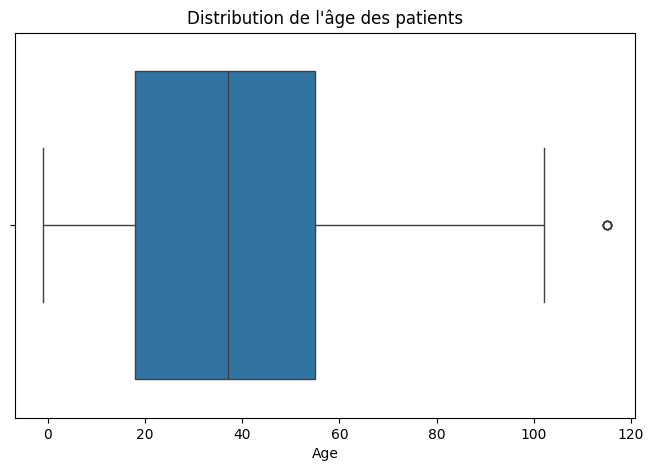

Valeur minimale d'âge : -1
Valeur maximale d'âge : 115


In [143]:
# Distribution des âges
plt.figure(figsize=(8, 5))
sns.boxplot(x=dataset_filtered["Age"])
plt.title("Distribution de l'âge des patients")
plt.show()

# Vérifier les valeurs min/max
print(f"Valeur minimale d'âge : {dataset_filtered['Age'].min()}")
print(f"Valeur maximale d'âge : {dataset_filtered['Age'].max()}")

In [144]:
# Suppression des âges négatifs et au-delà de 100 ans
dataset_filtered = dataset_filtered[(dataset_filtered["Age"] >= 0) & (dataset_filtered["Age"] <= 100)]

# Vérification
print(f"Nouvelle valeur minimale d'âge : {dataset_filtered['Age'].min()}")
print(f"Nouvelle valeur maximale d'âge : {dataset_filtered['Age'].max()}")

Nouvelle valeur minimale d'âge : 0
Nouvelle valeur maximale d'âge : 100


In [145]:
# Convertir la target en numérique
dataset_filtered['No-show'] = dataset_filtered['No-show'].map({'Yes': 1, 'No': 0})

In [146]:
dataset_filtered.head()

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,DaysUntilAppointment
0,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,Quartier Saint-Germain-l'Auxerrois,0,1,0,0,0,0,0,1
1,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,Quartier Saint-Germain-l'Auxerrois,0,0,0,0,0,0,0,1
2,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,Quartier des Halles,0,0,0,0,0,0,0,1
3,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,Quartier du Palais-Royal,0,0,0,0,0,0,0,1
4,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,Quartier Saint-Germain-l'Auxerrois,0,1,1,0,0,0,0,1


In [147]:
# Séparation de la variable cible et des caractéristiques
print("Separating labels from features...")
target_variable = "No-show"

# Vérification de l'existence de la variable cible dans le jeu de données
if target_variable in dataset_filtered.columns:
    X = dataset_filtered.drop(columns=[target_variable])
    Y = dataset_filtered[target_variable]
    print("...Done.\n")

    print("Y (Target Variable):")
    print(Y.head(), "\n")
    
    print("X (Features):")
    print(X.head())
else:
    print(f"Error: The target variable '{target_variable}' does not exist in the dataset.")

Separating labels from features...
...Done.

Y (Target Variable):
0    0
1    0
2    0
3    0
4    0
Name: No-show, dtype: int64 

X (Features):
  Gender              ScheduledDay            AppointmentDay  Age  \
0      F 2016-04-29 18:38:08+00:00 2016-04-29 00:00:00+00:00   62   
1      M 2016-04-29 16:08:27+00:00 2016-04-29 00:00:00+00:00   56   
2      F 2016-04-29 16:19:04+00:00 2016-04-29 00:00:00+00:00   62   
3      F 2016-04-29 17:29:31+00:00 2016-04-29 00:00:00+00:00    8   
4      F 2016-04-29 16:07:23+00:00 2016-04-29 00:00:00+00:00   56   

                        Neighbourhood  Scholarship  Hypertension  Diabetes  \
0  Quartier Saint-Germain-l'Auxerrois            0             1         0   
1  Quartier Saint-Germain-l'Auxerrois            0             0         0   
2                 Quartier des Halles            0             0         0   
3            Quartier du Palais-Royal            0             0         0   
4  Quartier Saint-Germain-l'Auxerrois            0

In [148]:
# Détection automatique des colonnes numériques et catégorielles
numeric_features = [col for col in X.columns if X[col].dtype in ['float64', 'int64', 'int32']]
categorical_features = [col for col in X.columns if X[col].dtype == 'object']

print("Found numeric features:", numeric_features)
print("Found categorical features:", categorical_features)

Found numeric features: ['Age', 'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'DaysUntilAppointment']
Found categorical features: ['Gender', 'Neighbourhood']


In [149]:
# Pipeline de transformation pour les caractéristiques numériques
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Met à l'échelle les données en les centrant et les réduisant
])

print("Numeric feature transformer pipeline created.")

Numeric feature transformer pipeline created.


In [150]:
# Pipeline de transformation pour les caractéristiques catégorielles
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first'))
])

print("Categorical feature transformer pipeline created.")

Categorical feature transformer pipeline created.


In [151]:
# Création de l'objet de prétraitement qui applique les transformations aux colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features), 
        ('cat', categorical_transformer, categorical_features)
    ]
)

print("Preprocessor object created with transformations for numeric and categorical features.")

Preprocessor object created with transformations for numeric and categorical features.


In [152]:
# Division du dataset en ensembles d'entraînement et de test
print("Dividing dataset into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print(f"Train set: {X_train.shape[0]} samples, Test set: {X_test.shape[0]} samples")
print("...Done.\n")

Dividing dataset into train and test sets...
Train set: 88415 samples, Test set: 22104 samples
...Done.



In [153]:
# Appliquer la transformation sur X_train et X_test
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Convertir en DataFrame Pandas avec les noms de colonnes
X_train = pd.DataFrame(X_train_transformed.toarray(), columns=preprocessor.get_feature_names_out())
X_test = pd.DataFrame(X_test_transformed.toarray(), columns=preprocessor.get_feature_names_out())

# Vérifier les résultats
print("X_train transformed (first 5 rows):")
display(X_train.head())

print("X_test transformed (first 5 rows):")
display(X_test.head())

X_train transformed (first 5 rows):


,num__Age,num__Scholarship,num__Hypertension,num__Diabetes,num__Alcoholism,num__Handcap,num__SMS_received,num__DaysUntilAppointment,cat__Gender_M,cat__Neighbourhood_Quartier Necker,...,cat__Neighbourhood_Quartier du Jardin-des-Plantes,cat__Neighbourhood_Quartier du Mail,cat__Neighbourhood_Quartier du Montparnasse,cat__Neighbourhood_Quartier du Palais-Royal,cat__Neighbourhood_Quartier du Parc-de-Montsouris,cat__Neighbourhood_Quartier du Petit-Montrouge,cat__Neighbourhood_Quartier du Pont-de-Flandre,cat__Neighbourhood_Quartier du Père-Lachaise,cat__Neighbourhood_Quartier du Val-de-Grâce,cat__Neighbourhood_Unknown
0,-1.561371,-0.330151,-0.496374,-0.2772,-0.177346,-0.138651,-0.688870,0.480179,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.220123,-0.330151,-0.496374,-0.2772,-0.177346,-0.138651,-0.688870,-0.667246,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.250923,-0.330151,-0.496374,-0.2772,-0.177346,-0.138651,1.451653,3.247497,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.604637,-0.330151,-0.496374,-0.2772,-0.177346,-0.138651,-0.688870,-0.599751,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.220123,-0.330151,-0.496374,-0.2772,-0.177346,-0.138651,-0.688870,-0.599751,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


X_test transformed (first 5 rows):


,num__Age,num__Scholarship,num__Hypertension,num__Diabetes,num__Alcoholism,num__Handcap,num__SMS_received,num__DaysUntilAppointment,cat__Gender_M,cat__Neighbourhood_Quartier Necker,...,cat__Neighbourhood_Quartier du Jardin-des-Plantes,cat__Neighbourhood_Quartier du Mail,cat__Neighbourhood_Quartier du Montparnasse,cat__Neighbourhood_Quartier du Palais-Royal,cat__Neighbourhood_Quartier du Parc-de-Montsouris,cat__Neighbourhood_Quartier du Petit-Montrouge,cat__Neighbourhood_Quartier du Pont-de-Flandre,cat__Neighbourhood_Quartier du Père-Lachaise,cat__Neighbourhood_Quartier du Val-de-Grâce,cat__Neighbourhood_Unknown
0,-1.345041,-0.330151,-0.496374,-0.2772,-0.177346,-0.138651,1.451653,0.142701,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.818262,-0.330151,-0.496374,-0.2772,-0.177346,-0.138651,-0.688870,-0.667246,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.220123,3.028917,-0.496374,-0.2772,-0.177346,-0.138651,-0.688870,-0.599751,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.436454,-0.330151,-0.496374,-0.2772,-0.177346,-0.138651,-0.688870,-0.599751,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.770116,-0.330151,2.014608,-0.2772,-0.177346,-0.138651,-0.688870,-0.532255,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [154]:
# Instancier le modèle de régression logistique avec liblinear
logistic_model = LogisticRegression(solver='saga', random_state=42, class_weight="balanced", C=0.1)

# Entraîner le modèle sur les données transformées
logistic_model.fit(X_train_transformed, Y_train)
print("...Training done.")

...Training done.


/home/user/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [155]:
# Prédire sur les données de test
Y_pred = logistic_model.predict(X_test_transformed)

In [156]:
# Calcul de l'accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calcul du F1-score (plus adapté aux classes déséquilibrées)
f1 = f1_score(Y_test, Y_pred)
print(f"F1-score: {f1:.4f}")

# Rapport détaillé des performances
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred))

Accuracy: 0.6545
F1-score: 0.3991

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.67      0.76     17679
           1       0.31      0.57      0.40      4425

    accuracy                           0.65     22104
   macro avg       0.58      0.62      0.58     22104
weighted avg       0.75      0.65      0.69     22104

